In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gsw
import scipy.signal as sp
import datetime as dt
from beam2ENU import beam2ENU
import seawater as sw
import oceans as oc

In [2]:
directory = '../../Data/deployment_raw/';
outdir = '../../plots/Ri/Ri_profile/';
deployment_name = 'deploy1_';
measurement_type = 'ctd_';
file_type = 'raw_'
profile = 0;

In [3]:
#Open the CTD data file that has all data stored as pandas
c_file = 'C'+("%07d" % (profile,))
a_file = 'A'+("%07d" % (profile,))
c_data = pd.read_pickle(directory+deployment_name+file_type+c_file)
a_data = pd.read_pickle(directory+deployment_name+file_type+a_file)

#Join CTD and ADCP data together (add time to CTD data)
start_time = a_data["a_time"].values[1][:-10]
start_time = dt.datetime.strptime(start_time,"%Y-%m-%dT%H:%M:%S")
start_time = start_time - dt.timedelta(seconds=15)
c_data["c_time"] = [start_time+dt.timedelta(seconds=x) for x in range(len(c_data["c_temp"].values))]
c_data.index = pd.DatetimeIndex(c_data['c_time'])

#And average ADCP to resample at 1Hz
a_data.index = pd.DatetimeIndex(a_data['a_time'])
a_data = a_data.resample('S').mean()
#Combine both datasets into one dataset by time
data = pd.concat([a_data, c_data], axis=1, sort=False).dropna(axis='rows')

# #Get the buoyancy frequency from CTD data
# CT = gsw.CT_from_t(data['c_sal'],data['c_temp'],data['c_pres'])
# SA = gsw.SA_from_SP(data['c_sal'],data['c_pres'],174,-43)
# [N2,p_mid,dp] = gsw.Nsquared(SA,CT,data['c_pres'])
# data['p_mid'] = np.append(p_mid,p_mid[-1])
# data['dp'] = np.append(dp.values,dp.values[-1])
# data['N2'] = np.append(N2.values,N2.values[-1])

# #Remove outliers for datasets
# data['N2'] = data['N2'].mask(((data['N2']-data['N2'].mean()).abs() > data['N2'].std()))
# data['N2'] = data['N2'].interpolate()
# plt.plot(data['N2'].values)
# plt.show()


C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\seawater\geostrophic.py:102: RuntimeWarning: divide by zero encountered in true_divide
  n2 = -mid_g * dif_pden / (dif_z * mid_pden)
C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\seawater\geostrophic.py:104: RuntimeWarning: divide by zero encountered in true_divide
  q = -cor * dif_pden / (dif_z * mid_pden)


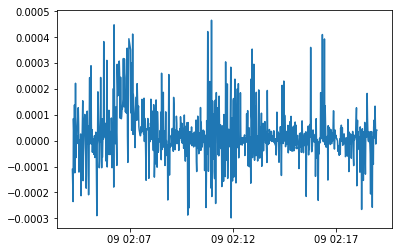

In [4]:
#ALternate N2 calculation
# [n2,q,p_ave] = sw.bfrq(data['c_sal'],data['c_temp'],data['c_pres'],-43)
# NN = [item[0] for item in n2]
# test = pd.DataFrame({'N2': NN})

# test = test.replace([np.inf, -np.inf], np.nan)
# test['N2'] = test['N2'].mask(((test['N2']-test['N2'].mean()).abs() > test['N2'].std()))
# test['N2'] = test['N2'].interpolate()
# data['N2'] = test['N2']
# plt.plot(data['N2'])
# plt.show()

[n2,q,p_ave] = sw.bfrq(data['c_sal'],data['c_temp'],data['c_pres'],-43)
N2 = [item[0] for item in n2]
data['N2'] = np.append(N2,N2[-1])

data['N2'] = data["N2"].replace([np.inf, -np.inf], np.nan)
data['N2'] = data['N2'].mask(((data['N2']-data['N2'].mean()).abs() > data['N2'].std()))
data['N2'] = data['N2'].interpolate()
plt.plot(data['N2'])
plt.show()


In [5]:
#Get shear magnitude 
[east,north,up] = beam2ENU([a_data["a_beam1"][0],a_data["a_beam2"][0],a_data["a_beam3"][0],a_data["a_beam4"][0]],a_data['a_heading'].values,a_data['a_pitch'].values,a_data['a_roll'].values,a_data['a_vel1'].values,a_data['a_vel2'].values,a_data['a_vel3'].values)
[shr, z_ave] = oc.sw_extras.shear(data['c_depth'].values,east,north)
data['shr'] = np.append(shr,shr[-1])
data['shr'] = data['shr'].replace([np.inf, -np.inf], np.nan)
data['shr'] = data['shr'].mask(((data['shr']-data['shr'].mean()).abs() > data['shr'].std()))
data['shr'] = data['shr'].interpolate()
data['shr2'] = data['shr']**2
data['shr2'] = data['shr2'].mask(((data['shr2']-data['shr2'].mean()).abs() > data['shr2'].std()))
data['shr2'] = data['shr2'].interpolate()
data['z_ave'] = np.append(z_ave,z_ave[-1])



C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\oceans\sw_extras\sw_extras.py:254: RuntimeWarning: divide by zero encountered in true_divide
  shr = np.sqrt((diff_east/ diff_z)**2 +(diff_north/ diff_z)**2)


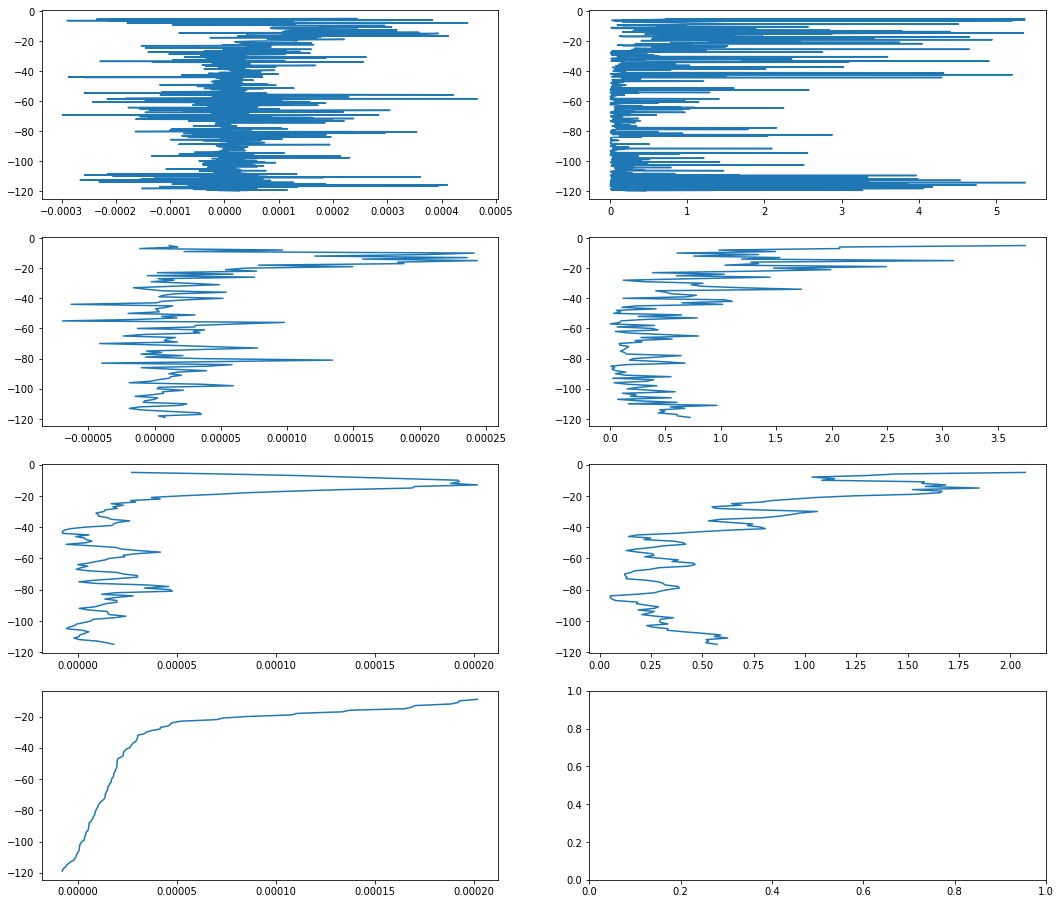

In [6]:
#Plots
fig1, axes = plt.subplots(4,2,figsize=(18, 16))
#All of the data
axes[0,0].plot(data['N2'],data['z_ave'])
axes[0,1].plot(data['shr2'],data['z_ave'])
#data binned by 1 meter
data['z_ave'] = data['z_ave'].round(0)
data = data.groupby(data['z_ave']).mean()
axes[1,0].plot(data['N2'],data['z_ave'])
axes[1,1].plot(data['shr2'],data['z_ave'])
#data smoothed by a rolling mean
data['N2'] = data['N2'].rolling(5).mean()
data['shr2'] = data['shr2'].rolling(5).mean()
axes[2,0].plot(data['N2'],data['z_ave'])
axes[2,1].plot(data['shr2'],data['z_ave'])
#sort the buoyancy frequency
data_sort = data.sort_values('N2', ascending=True)
axes[3,0].plot(data_sort['N2'],data['z_ave'])

plt.show()

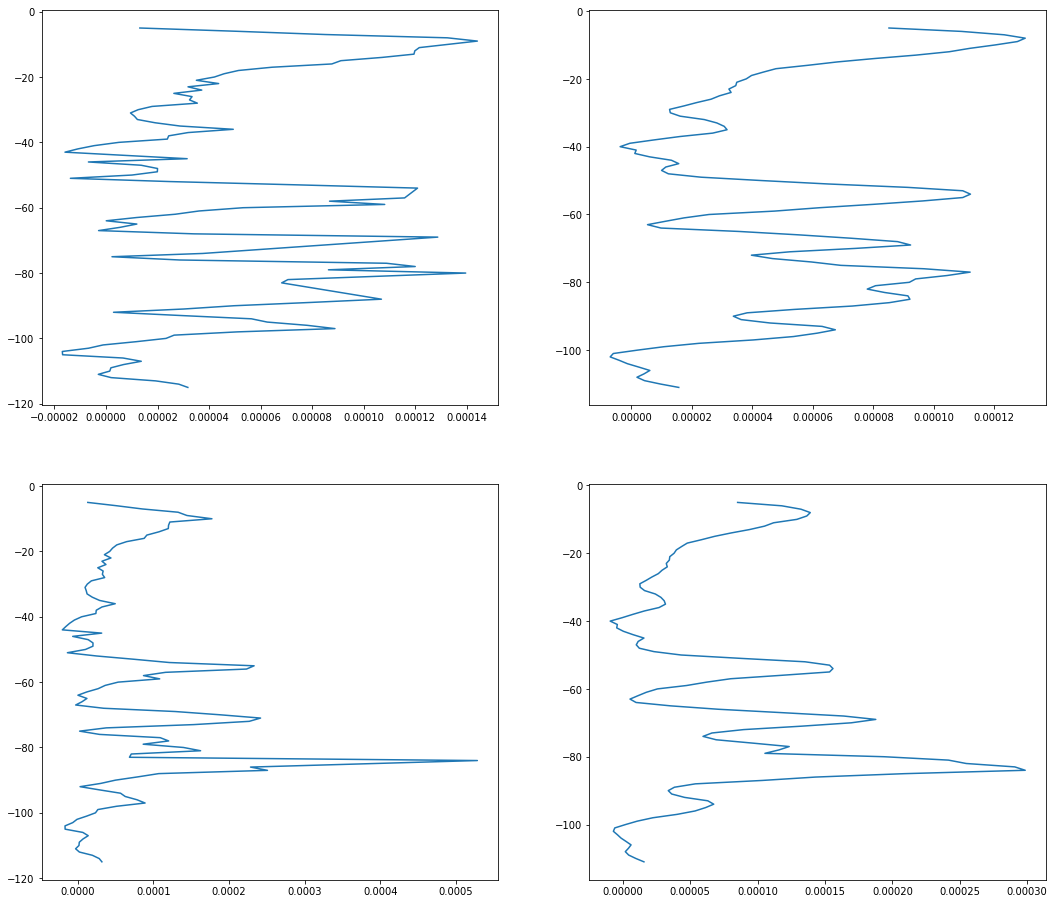

In [7]:
#Make Richardson number 
data['Ri_sort'] = data_sort['N2']/data['shr2']
data['Ri'] = data['N2']/data['shr2']
#data['Ri'] = data['Ri'].mask(data['Ri'] > 1)
#data['Ri'] = data['Ri'].mask(data['Ri'] < -1)
data['Ri'] = data['Ri'].mask(((data['Ri']-data['Ri'].mean()).abs() > data['Ri'].std()))
data['Ri'] = data['Ri'].interpolate()

#Plot richardson number
fig2, axes2 = plt.subplots(2,2,figsize=(18, 16))
axes2[0,0].plot(data['Ri'],data['z_ave'])
data['Ri'] = data['Ri'].interpolate().rolling(5).mean()
axes2[0,1].plot(data['Ri'],data['z_ave'])

axes2[1,0].plot(data['Ri_sort'],data['z_ave'])
data['Ri_sort'] = data['Ri_sort'].interpolate().rolling(5).mean()
axes2[1,1].plot(data['Ri_sort'],data['z_ave'])


plt.show()